In [1]:
import os, glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def read_subset(dir_path, w, h, sample_size=None):
    """
    디스크로부터 chest-xray-pneumonia 데이터셋을 로드하고,
    Y는 0이면 NORMAL, 1이면 PNEUMONIA
    
    :param w: width
    :param h: height
    :param dir_path: str, 원본 데이터셋이 저장된 디렉터리 경로.
    :param sample_size: int, 전체 데이터셋을 모두 사용하지 않는 경우, 사용하고자 하는 샘플 이미지 개수.
    """

    # 정상인 경우와 폐렴인 경우
    categories = ['NORMAL', 'PNEUMONIA']
    np_classes = len(categories)
    
    x = []
    y = []
    
    for idx, category in enumerate(categories):
        print('idx :: ', idx, 'category :: ', category)
        img_dir_detail = dir_path + '/' + category
        files = glob.glob(img_dir_detail + '/*.jpeg')
        
        print('img_dir_detail :: ',img_dir_detail)
        
        nSize = 0
        
        for i, f in enumerate(files):
            try:
                
                if sample_size is not None and nSize > sample_size:
                    break
                
                img = Image.open(f)
                img = img.convert('RGB')

                # 사이즈 변환
                img = img.resize((w, h))

                data = np.asarray(img)

                # Y는 0이면 NORMAL, 1이면 PNEUMONIA
                x.append(data)
                y.append(idx)
                
                nSize = nSize + 1
                
            except Exception as ex:
                print(category, str(i) + '번째 에러 발생 :: ')
                print(ex)
    
    x = np.array(x)
    y = np.array(y)
    
    return x, y
    

In [22]:
# train 데이터 로드
x_train, y_train = read_subset('./chest_xray/train', 64, 64)

idx ::  0 category ::  NORMAL
img_dir_detail ::  ./chest_xray/train/NORMAL
idx ::  1 category ::  PNEUMONIA
img_dir_detail ::  ./chest_xray/train/PNEUMONIA


In [23]:
# test 데이터 로드
x_test, y_test = read_subset('./chest_xray/test', 64, 64)

idx ::  0 category ::  NORMAL
img_dir_detail ::  ./chest_xray/test/NORMAL
idx ::  1 category ::  PNEUMONIA
img_dir_detail ::  ./chest_xray/test/PNEUMONIA


In [24]:
# numpy 형태로 저장
xy = (x_train, x_test, y_train, y_test)
np.save('./numpy_data/binary_image_chest_0621_v2_64.npy', xy)

In [25]:
X_train, X_test, y_train, y_test = np.load('./numpy_data/binary_image_chest_0621_v2_64.npy')

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(5216, 64, 64, 3)
(624, 64, 64, 3)
(5216,)
(624,)


In [27]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
import numpy as np
import keras.backend.tensorflow_backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

Using TensorFlow backend.


In [28]:
def deep_cnn_advanced_nin_v2():
    model = Sequential()
    
    model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
    # 1x1 convolution
    model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    # 1x1 convolution
    model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
    # 1x1 convolution
    model.add(Conv2D(filters = 25, kernel_size = (1,1), strides = (1,1), padding = 'valid', kernel_initializer='he_normal'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [29]:
model_dir = './model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path = model_dir + "/chest_0621_v2_64.model"
    
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

In [30]:
# 64x64
model = deep_cnn_advanced_nin_v2()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 25)        825       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 16, 16, 25)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 16, 16, 64)        14464     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 16, 16, 25)        1625      
__________

In [61]:
# 128x128
model = deep_cnn_advanced_nin_v2()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 64, 64, 25)        825       
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 32, 32, 25)        0         
_________________________________________________________________
conv2d_36 (Conv2D)           (None, 32, 32, 64)        14464     
_________________________________________________________________
conv2d_37 (Conv2D)           (None, 32, 32, 25)        1625      
__________

In [31]:
# Train
#history = model.fit(X_train, y_train, batch_size=64, epochs=100, verbose=1, validation_split=0.2, shuffle=True)

history_64 = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Train on 4172 samples, validate on 1044 samples
Epoch 1/100
4172/4172 [==============================] - 43s 10ms/step - loss: 0.6193 - acc: 0.6755 - val_loss: 0.2757 - val_acc: 1.0000

Epoch 00001: val_loss improved from inf to 0.27572, saving model to ./model/chest_0621_v2_64.model
Epoch 2/100
4172/4172 [==============================] - 39s 9ms/step - loss: 0.3456 - acc: 0.8526 - val_loss: 0.2256 - val_acc: 0.8937

Epoch 00002: val_loss improved from 0.27572 to 0.22565, saving model to ./model/chest_0621_v2_64.model
Epoch 3/100
4172/4172 [==============================] - 39s 9ms/step - loss: 0.2281 - acc: 0.9056 - val_loss: 0.1086 - val_acc: 0.9550

Epoch 00003: val_loss improved from 0.22565 to 0.10858, saving model to ./model/chest_0621_v2_64.model
Epoch 4/100
4172/4172 [==============================] - 40s 9ms/step - loss: 0.1702 - acc: 0.9283 - val_loss: 0.1643 - val_acc: 0.9301

Epoch 00004: val_loss did not improve from 0.10858
Epoch 5/100
4172/4172 [========================

In [62]:
history_128 = model.fit(X_train, y_train, batch_size=128, epochs=100, validation_split=0.2, callbacks=[checkpoint, early_stopping])

Train on 4172 samples, validate on 1044 samples
Epoch 1/100
4172/4172 [==============================] - 206s 49ms/step - loss: 0.5282 - acc: 0.7308 - val_loss: 0.6400 - val_acc: 0.6580

Epoch 00001: val_loss improved from inf to 0.64003, saving model to ./model/chest_0621_v2_128.model
Epoch 2/100
4172/4172 [==============================] - 203s 49ms/step - loss: 0.2223 - acc: 0.9094 - val_loss: 0.1696 - val_acc: 0.9215

Epoch 00002: val_loss improved from 0.64003 to 0.16959, saving model to ./model/chest_0621_v2_128.model
Epoch 3/100
4172/4172 [==============================] - 198s 48ms/step - loss: 0.1496 - acc: 0.9475 - val_loss: 0.0856 - val_acc: 0.9646

Epoch 00003: val_loss improved from 0.16959 to 0.08565, saving model to ./model/chest_0621_v2_128.model
Epoch 4/100
4172/4172 [==============================] - 200s 48ms/step - loss: 0.1109 - acc: 0.9573 - val_loss: 0.0413 - val_acc: 0.9828

Epoch 00004: val_loss improved from 0.08565 to 0.04128, saving model to ./model/chest_06

In [32]:
%%time
print("64 정확도 : %.2f " %(model.evaluate(X_test, y_test)[1]))

624/624 [==============================] - 3s 4ms/step
64 정확도 : 0.83 
Wall time: 2.8 s


In [63]:
%%time
print("128 정확도 : %.2f " %(model.evaluate(X_test, y_test)[1]))

624/624 [==============================] - 10s 16ms/step
128 정확도 : 0.75 
Wall time: 10.2 s


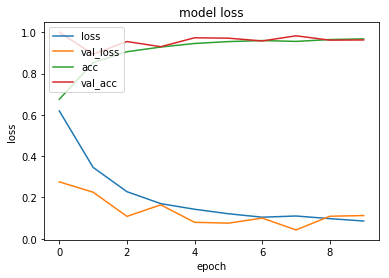

In [33]:
plt.plot(history_64.history['loss'])
plt.plot(history_64.history['val_loss'])
plt.plot(history_64.history['acc'])
plt.plot(history_64.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.show()

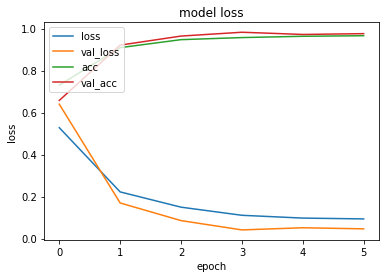

In [64]:
plt.plot(history_128.history['loss'])
plt.plot(history_128.history['val_loss'])
plt.plot(history_128.history['acc'])
plt.plot(history_128.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.show()

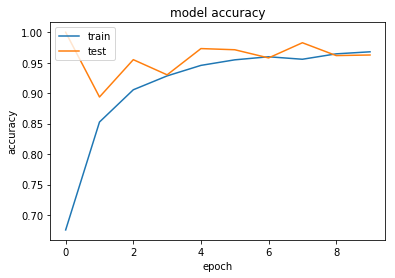

In [34]:
plt.plot(history_64.history['acc'])
plt.plot(history_64.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

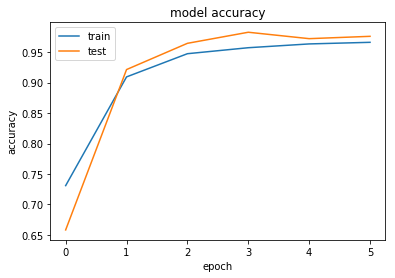

In [65]:
plt.plot(history_128.history['acc'])
plt.plot(history_128.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [35]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

In [36]:
xhat = X_test
yhat = model.predict(xhat)
print('## xhat ##')
print(xhat)
print('## yhat ##')
print(yhat)

## xhat ##
[[[[0.12156863 0.12156863 0.12156863]
   [0.12156863 0.12156863 0.12156863]
   [0.11372549 0.11372549 0.11372549]
   ...
   [0.13333334 0.13333334 0.13333334]
   [0.12156863 0.12156863 0.12156863]
   [0.1254902  0.1254902  0.1254902 ]]

  [[0.12941177 0.12941177 0.12941177]
   [0.11764706 0.11764706 0.11764706]
   [0.09803922 0.09803922 0.09803922]
   ...
   [0.12156863 0.12156863 0.12156863]
   [0.13333334 0.13333334 0.13333334]
   [0.12156863 0.12156863 0.12156863]]

  [[0.13333334 0.13333334 0.13333334]
   [0.12156863 0.12156863 0.12156863]
   [0.11372549 0.11372549 0.11372549]
   ...
   [0.10980392 0.10980392 0.10980392]
   [0.11764706 0.11764706 0.11764706]
   [0.11372549 0.11372549 0.11372549]]

  ...

  [[0.11372549 0.11372549 0.11372549]
   [0.11372549 0.11372549 0.11372549]
   [0.10980392 0.10980392 0.10980392]
   ...
   [0.12941177 0.12941177 0.12941177]
   [0.12941177 0.12941177 0.12941177]
   [0.14117648 0.14117648 0.14117648]]

  [[0.11372549 0.11372549 0.113725

In [37]:
idx=0
yhat_arr = yhat

# metrics 구성을 위해 Y데이터 맞추기
# 0.5보다 크면 폐렴(1) 이고, else면 정상(0) 이다.

for y in yhat:
    if y >= 0.5:
        yhat_arr[idx] = int(1)
    else:
        yhat_arr[idx] = int(0)
    
    idx+=1

In [38]:
yhat_arr

array([[0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.],
       [1.],
       [0.],
       [0.],
       [0.],
       [0.],

In [39]:
# 64x64
print('accuracy {:.3f}'.format(accuracy_score(y_test, yhat_arr)))
print('precision {:.3f}'.format(precision_score(y_test,yhat_arr)))
print('recall {:.3f}'.format(recall_score(y_test,yhat_arr)))
print('f1 {:.3f}'.format(f1_score(y_test,yhat_arr) ))
print('=======================================================')
print(classification_report(y_test,yhat_arr))
print('=======================================================')
print(confusion_matrix(y_test,yhat_arr))

accuracy 0.825
precision 0.789
recall 0.985
f1 0.876
              precision    recall  f1-score   support

           0       0.96      0.56      0.71       234
           1       0.79      0.98      0.88       390

   micro avg       0.83      0.83      0.83       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.83      0.81       624

[[131 103]
 [  6 384]]


In [68]:
# 128x128
print('accuracy {:.3f}'.format(accuracy_score(y_test, yhat_arr)))
print('precision {:.3f}'.format(precision_score(y_test,yhat_arr)))
print('recall {:.3f}'.format(recall_score(y_test,yhat_arr)))
print('f1 {:.3f}'.format(f1_score(y_test,yhat_arr) ))
print('=======================================================')
print(classification_report(y_test,yhat_arr))
print('=======================================================')
print(confusion_matrix(y_test,yhat_arr))

accuracy 0.747
precision 0.713
recall 0.995
f1 0.831
              precision    recall  f1-score   support

           0       0.97      0.33      0.50       234
           1       0.71      0.99      0.83       390

   micro avg       0.75      0.75      0.75       624
   macro avg       0.84      0.66      0.66       624
weighted avg       0.81      0.75      0.71       624

[[ 78 156]
 [  2 388]]


In [42]:
from keras.models import load_model
import tensorflow as tf

def predict_new_img(w,h,model_path):
    seed = 5
    tf.set_random_seed(seed)
    np.random.seed(seed)

    caltech_dir = './chest_xray/img_test'

    pixels = w * h * 3

    X = []
    filenames = []
    files = glob.glob(caltech_dir+"/*.*")
    for i, f in enumerate(files):
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((w, h))
        data = np.asarray(img)

        filenames.append(f)
        X.append(data)


    #print(filenames)

    X = np.array(X)
    X = X.astype(float) / 255
    #model = load_model('./model/chest_0621_v1.model')
    model = load_model(model_path)

    prediction = model.predict(X)
    np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})

    cnt = 0
    for i in prediction:
        if i >= 0.5: print("해당 " + filenames[cnt].split("\\")[1] + "  이미지는 폐렴으로 추정됩니다.")
        else : print("해당 " + filenames[cnt].split("\\")[1] + "  이미지는 정상으로 추정됩니다.")
        cnt += 1

In [43]:
# 64 x 64
predict_new_img(64,64,'./model/chest_0621_v2_64.model')

해당 NORMAL2-IM-1427-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1430-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1431-0001.jpeg  이미지는 정상으로 추정됩니다.
해당 NORMAL2-IM-1436-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1437-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1438-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1440-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1442-0001.jpeg  이미지는 정상으로 추정됩니다.
해당 person1946_bacteria_4874.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1946_bacteria_4875.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1947_bacteria_4876.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1949_bacteria_4880.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1950_bacteria_4881.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1951_bacteria_4882.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1952_bacteria_4883.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1954_bacteria_4886.jpeg  이미지는 폐렴으로 추정됩니다.


In [72]:
#128 x 128
predict_new_img(128,128,'./model/chest_0621_v2_128.model')

해당 NORMAL2-IM-1427-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1430-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1431-0001.jpeg  이미지는 정상으로 추정됩니다.
해당 NORMAL2-IM-1436-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1437-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1438-0001.jpeg  이미지는 폐렴으로 추정됩니다.
해당 NORMAL2-IM-1440-0001.jpeg  이미지는 정상으로 추정됩니다.
해당 NORMAL2-IM-1442-0001.jpeg  이미지는 정상으로 추정됩니다.
해당 person1946_bacteria_4874.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1946_bacteria_4875.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1947_bacteria_4876.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1949_bacteria_4880.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1950_bacteria_4881.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1951_bacteria_4882.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1952_bacteria_4883.jpeg  이미지는 폐렴으로 추정됩니다.
해당 person1954_bacteria_4886.jpeg  이미지는 폐렴으로 추정됩니다.
